In [92]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import pickle

In [93]:
# Load dataset
full_data = pd.read_csv('amazon.csv')
print("Original shape:", full_data.shape)

Original shape: (1465, 16)


In [94]:
# Drop irrelevant columns
columns_to_drop = [
    'product_name', 'category', 'discounted_price', 'actual_price',
    'discount_percentage', 'about_product', 'user_name', 'review_id',
    'review_title', 'review_content', 'img_link', 'product_link',
    'rating_count'
]
data = full_data.drop(columns=columns_to_drop)
print("After dropping columns:", data.shape)

After dropping columns: (1465, 3)


# Check the distribution of the rating

/home/ubuntu/MLPRO/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/MLPRO/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


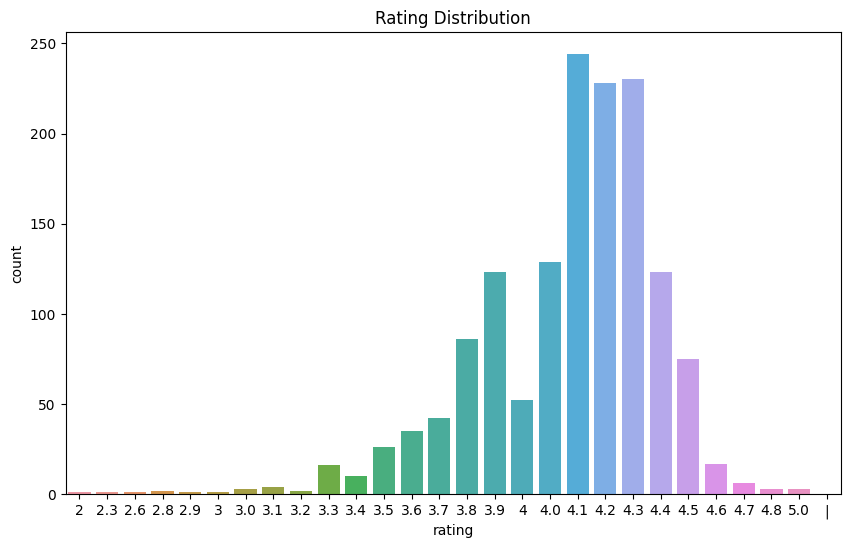

In [95]:
# Visualize ratings using countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=data[data['rating'] != '|'], x='rating', order=sorted(data['rating'].unique()))
plt.title("Rating Distribution")
plt.show()

In [96]:
# Data cleaning
data = data.dropna()
data = data[data['rating'] != '|']
data['rating'] = data['rating'].astype(float)

In [97]:
# Encode categorical values
product_id_encoder = LabelEncoder()
user_id_encoder = LabelEncoder()

In [98]:
data['product_id'] = product_id_encoder.fit_transform(data['product_id'])
data['user_id'] = user_id_encoder.fit_transform(data['user_id'])

In [99]:
# Save encoder for future use
with open('product_id_encoder.pkl', 'wb') as f:
    pickle.dump(product_id_encoder, f)

In [100]:
data

,product_id,rating,user_id
0,346,4.2,623
1,847,4.0,88
2,818,3.9,848
3,643,4.2,254
4,588,4.2,17
...,...,...,...
1460,672,4.0,1049
1461,201,4.1,425
1462,27,3.6,864
1463,61,4.0,300


In [101]:
# Create pivot-like matrix (product × user with rating)
pivot_data = data.pivot_table(index='product_id', columns='user_id', values='rating').fillna(0)
pivot_data.to_csv('Test_data.csv')  # Save for inference use

In [102]:
pivot_table = data.pivot_table(
    index='product_id',
    columns='user_id',
    values='rating'
).fillna(0)

# Splitting the dataset


In [103]:
Train, Test = train_test_split(data, test_size=0.2, random_state=42)

In [104]:
Train.head()

,product_id,rating,user_id
1331,557,3.9,1188
724,3,4.3,47
254,436,3.6,94
1068,295,3.9,1017
1193,308,3.7,401


In [105]:
Test.head()

,product_id,rating,user_id
1297,236,4.2,1170
175,947,3.7,615
275,955,3.3,220
548,680,4.3,1031
1000,1158,3.9,71


# Model


In [106]:
# Train KNN model
model = NearestNeighbors(metric='cosine', algorithm='brute')

In [107]:
model.fit(pivot_data)

NearestNeighbors(algorithm='brute', metric='cosine')

In [109]:
# Predict using same pivot_table structure
distances, indices = model.kneighbors(pivot_table, n_neighbors=6)

In [110]:
distances

array([[0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1.],
       ...,
       [0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1.]])

In [111]:
indices

array([[   0,  904,  901,  902,  899,  903],
       [  13,    1,   15,  901,  900,  903],
       [   2,  902,  904,  900,  901,  898],
       ...,
       [1347,  902,  904,  900,  901,  898],
       [1348,  902,  904,  900,  901,  898],
       [1349,  904,  901,  902,  899,  903]])

In [112]:
# Save model, pivot_table, and product_id_encoder in one file
with open('model.pkl', 'rb') as f:
    model, pivot_table, product_id_encoder = pickle.load(f)

print("Model and encoder saved.")

Model and encoder saved.


# Prediction

In [115]:
def get_recommendations_with_details(product_id=0, n_recommendations=5):
    try:
        original_product_id = product_id_encoder.inverse_transform([product_id])[0]
        product_index = pivot_table.index.get_loc(product_id)

        distances, indices = model.kneighbors(
            pivot_table.iloc[[product_index]], n_neighbors=n_recommendations + 1
        )

        recommendations = []
        for j in range(1, len(indices[0])):  # skip self
            try:
                recommended_index = indices[0][j]
                recommended_encoded_id = pivot_table.index[recommended_index]
                recommended_original_id = product_id_encoder.inverse_transform([recommended_encoded_id])[0]

                product_info = full_data[full_data['product_id'] == recommended_original_id].iloc[0]

                recommendations.append({
                    'product_id': recommended_original_id,
                    'product_name': product_info['product_name'],
                    'category': product_info['category'],
                    'rating': product_info['rating'],
                    'rating_count': product_info['rating_count'],
                    'img_link': product_info['img_link'],
                    'product_link': product_info['product_link'],
                    'distance': distances[0][j]
                })
            except Exception as e:
                print(f"Inner Error: {e}")
                continue

        return recommendations

    except Exception as e:
        print("Main Error:", e)
        return [{"error": str(e)}]


In [116]:
# Test recommendation
print("Sample Recommendation:\n")
result = get_recommendations_with_details(product_id=100, n_recommendations=5)
for r in result:
    print(r)

Sample Recommendation:

{'product_id': 'B09G2VTHQM', 'product_name': 'AGARO Classic Portable Yogurt Maker, 1.2L Capacity, Electric, Automatic, Grey and White, Medium (33603)', 'category': 'Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances|YogurtMakers', 'rating': '4.1', 'rating_count': '557', 'img_link': 'https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/310umqMFDRL._SX300_SY300_QL70_FMwebp_.jpg', 'product_link': 'https://www.amazon.in/AGARO-Portable-Capacity-Automatic-33603/dp/B09G2VTHQM/ref=sr_1_362?qid=1672923610&s=kitchen&sr=1-362', 'distance': 1.0}
{'product_id': 'B09FPP3R1D', 'product_name': 'Glen 3 in 1 Electric Multi Cooker - Steam, Cook & Egg Boiler with 350 W (SA 3035MC) - 350 Watts', 'category': 'Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances|EggBoilers', 'rating': '4.1', 'rating_count': '827', 'img_link': 'https://m.media-amazon.com/images/I/31afXBXOUVL._SX300_SY300_QL70_FMwebp_.jpg', 'product_link': 'https://www.amazon.in/Glen-Electric-Multi-

In [ ]:
'''def get_recommendations_for_product2(model, data, n_recommendations, product_id):
    # Inverse transform the label-encoded product_id to get the original product_id
    original_product_id = product_id_encoder.inverse_transform([product_id])[0]

    # Find the index of the original product_id in the data DataFrame
    product_index = full_data[full_data['product_id'] == original_product_id].index[0]

    # Compute recommendations for the specified product
    distances, indices = model.kneighbors(data.iloc[product_index].values.reshape(1, -1))

    # Print details of recommended products
    print(f"Recommendations for product with original ID {original_product_id}:")
    original=full_data.loc[full_data['product_id'] == original_product_id].iloc[0]
    print(f"   Product Name: {original['product_name']}")
    print(f"   Category: {original['category']}")
    print("\n")
    for j in range(1, n_recommendations + 1):
        try:
            recommended_index = indices[0][j]
            recommended_original_id = product_id_encoder.inverse_transform([recommended_index])[0]
            distance = distances[0][j]
            # Retrieve details of the recommended product from the full_data DataFrame
            recommended_product_details = full_data[full_data['product_id'] == recommended_original_id].iloc[0]
            print(f"{j}: Product ID: {recommended_original_id}, Distance: {distance}")
            # You can also print additional details of the recommended product
            print(f"   Product Name: {recommended_product_details['product_name']}")
            print(f"   Category: {recommended_product_details['category']}")
            # Add more details as needed
        except:
            print(f"No more recommendations")
            continue
        print("\n")
'''

In [ ]:
# Example usage:
#get_recommendations_for_product2(model, data, 5, 11) 

Recommendations for product with original ID B0085IATT6:
   Product Name: D-Link DIR-615 Wi-fi Ethernet-N300 Single_band 300Mbps Router, Mobile App Support, Router | AP | Repeater | Client Modes(Black)
   Category: Computers&Accessories|NetworkingDevices|Routers


1: Product ID: B09MTLG4TP, Distance: 1.4757618989058585e-06
   Product Name: SAIELLIN Electric Lint Remover for Clothes Fabric Shaver Lint Shaver for Woolen Clothes Blanket Jackets Stainless Steel Blades, Clothes and Furniture Lint Roller for Fabrics Portable Lint Shavers (White Orange)
   Category: Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cleaning&Ironing|Irons,Steamers&Accessories|LintShavers


2: Product ID: B08CTQP51L, Distance: 2.4761762401626086e-06
   Product Name: Robustrion [Anti-Scratch] & [Smudge Proof] [S Pen Compatible] Premium Tempered Glass Screen Protector for Samsung Tab S6 Lite 10.4 inch SM-P610/615 [Bubble Free]
   Category: Computers&Accessories|Accessories&Peripherals|TabletAccessories|ScreenProtectors


/home/ubuntu/MLPRO/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
#import pickle

In [ ]:
# During model training / setup
'''with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
'''    

In [ ]:
#pickle.dump(model,open('model.pkl', 'wb') )

In [ ]:
#data.to_csv('Test_data.csv')

In [ ]:
#model = pickle.load(open('model.pkl', 'rb'))

In [ ]:
'''def get_recommendations_with_details(model=model, data=data, n_recommendations=5, product_id=0):
    # Inverse transform the label-encoded product_id to get the original product_id
    original_product_id = product_id_encoder.inverse_transform([product_id])[0]

    # Find the index of the original product_id in the data DataFrame
    product_index = full_data[full_data['product_id'] == original_product_id].index[0]

    # Compute recommendations for the specified product
    distances, indices = model.kneighbors(data.iloc[product_index].values.reshape(1, -1))

    recommendations = []

    for j in range(1, n_recommendations + 1):
        try:
            recommended_index = indices[0][j]
            recommended_original_id = product_id_encoder.inverse_transform([recommended_index])[0]
            distance = distances[0][j]

            # Retrieve details of the recommended product from the full_data DataFrame
            recommended_product_details = full_data[full_data['product_id'] == recommended_original_id].iloc[0]

            recommendation_info = {
                'product_id': recommended_original_id,
                'product_name': recommended_product_details['product_name'],
                'category': recommended_product_details['category'],
                'rating': recommended_product_details['rating'],
                'rating_count': recommended_product_details['rating_count'],
                'img_link': recommended_product_details['img_link'],
                'product_link': recommended_product_details['product_link'],
                'distance': distance
            }

            recommendations.append(recommendation_info)

        except:
            print(f"No more recommendations")
            continue

    return recommendations
'''    


In [117]:
data.nunique()

product_id    1350
rating          25
user_id       1193
dtype: int64

In [ ]:
#full_data.nunique()

product_id             1351
product_name           1337
category                211
discounted_price        550
actual_price            449
discount_percentage      92
rating                   28
rating_count           1143
about_product          1293
user_id                1194
user_name              1194
review_id              1194
review_title           1194
review_content         1212
img_link               1412
product_link           1465
dtype: int64